<h2>Portfolio allocation using Gaussian Process Latent Variable Model (GP-LVM) and 
Markowitz portfolio theory</h2>

<p>In this notebook we look at how the constructed covariance matrix $K$ for different kernels perform, if we build a portfolio.</p>

<b>Way of proceeding:</b>
<ol>
    <li>get returns of $N$ stocks on $D$ different times (e.g. $D$ days)</li>
    <li>put the $N \times D$ matrix into the GP-LVM model to learn the pairwise correlation matrix $K$ between the $N$ stocks</li>
    <li>calculate the weights $w$ for the minimal risk portfolio (i.e. $w = \text{min}_w (w^T K w)$ for fixed $K$)</li>
    <li>compare the resulting performance for different kernel-functions</li>
</ol>

In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystan
from datetime import datetime, timedelta

%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

from py_code.stan_gplvm import get_stan_code, vb, optimize
from py_code.helper_functions import get_kernel_function, minimal_variance_portfolio

<h2>Read necessary data into pandas dataframe</h2>

We need the data to be in the following format: <br>
    $N$: Number of stocks <br>
    $D$: Number of days <br>
    Dataframe: $D \times N$ <br>
    
For the GP-LVM we are going to work with the transposed $N \times D$ matrix afterwards

In [4]:
data = pd.read_csv('data/example_portfolio_performance.csv', 
                   index_col=0, parse_dates=['Date'])

#######
print( "number of nan's: {}".format(data.isna().sum().sum()) )
print( "shape data: {}".format(data.shape) )

print( "start_date: {}\nend_date: {}".format(data.index[0], data.index[-1]))
data.head()

number of nan's: 0
shape data: (4527, 100)
start_date: 2000-01-04 00:00:00
end_date: 2017-12-29 00:00:00


,SPG,NKE,GWW,ANDV,ED,MDT,BWA,LB,T,AET,...,YUM,AFL,ANSS,KR,VRTX,UNM,LMT,ARE,RHT,PCAR
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.011050,-0.054545,-0.028571,-0.029070,0.012963,0.007299,0.000000,-0.020031,-0.058511,-0.016873,...,-0.020100,-0.026536,-0.028249,0.033003,-0.079867,-0.018443,0.033950,-0.022000,-0.071274,-0.045977
2000-01-05,0.008380,0.057692,0.014006,-0.011976,0.045704,0.062827,0.004847,-0.014152,0.015537,-0.006865,...,0.005128,-0.005739,0.005814,0.015975,-0.016275,-0.033403,0.005970,-0.018405,0.190698,0.040663
2000-01-06,0.024931,-0.005195,-0.004144,-0.018182,0.001748,0.037542,-0.012862,-0.015948,-0.021110,0.001152,...,-0.008503,0.020202,0.000000,-0.037736,-0.014706,0.021598,0.014837,-0.018750,-0.108398,-0.013025
2000-01-07,0.043243,0.000000,-0.015257,-0.012346,0.006981,0.111842,0.027687,0.006483,0.008571,0.065593,...,-0.022298,0.019802,0.000000,-0.009804,0.087687,0.014800,0.002924,0.019108,0.158817,0.038123
2000-01-10,0.010363,0.016971,0.043662,-0.012499,-0.025996,-0.007397,-0.011093,-0.012882,0.014164,-0.018359,...,0.040351,-0.059639,0.005780,-0.026403,0.030875,-0.004167,-0.037901,0.012500,0.068053,0.040960


plot of first 20 stocks.


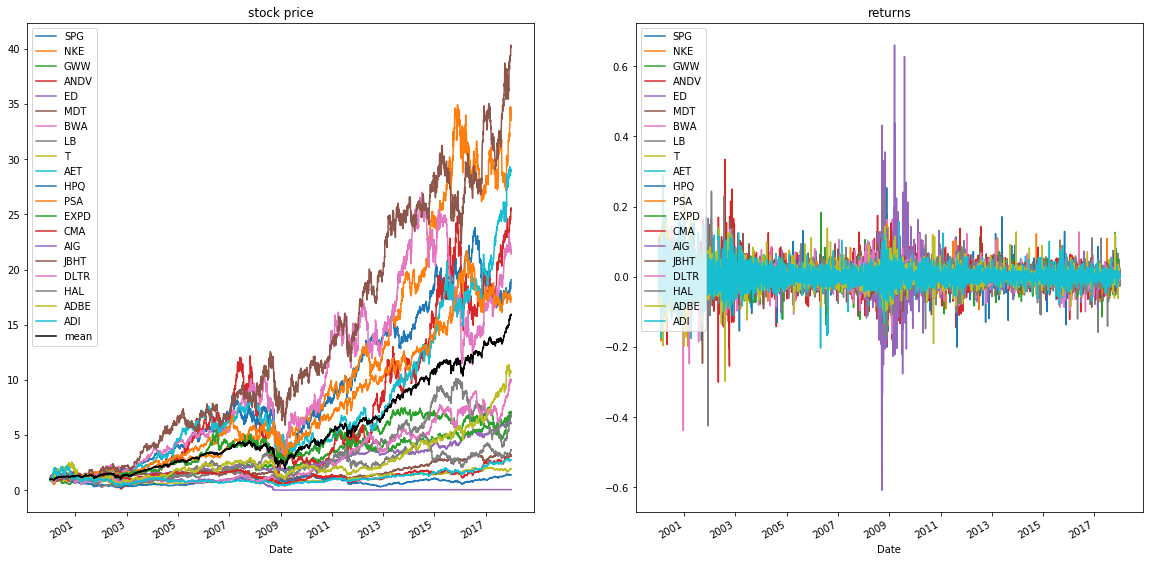

In [5]:
start = datetime.strptime('2000-01-01', '%Y-%m-%d')  # data.index[0]
end = datetime.strptime('2018-01-01', '%Y-%m-%d')    # data.index[-1]

# fill missing values with 0
data.fillna(value=0, inplace=True)


## visualize cumulative returns and returns we are going to work with
N_plot = 20
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(121)
np.cumprod(1+data.iloc[:, :N_plot], axis=0).plot(ax=ax, title='stock price')
np.cumprod(1+data.iloc[:, :N_plot].mean(axis=1)).plot(ax=ax, 
                                                      label='mean', 
                                                      color='black')
ax.legend()

ax = fig.add_subplot(122)
data.iloc[:, :N_plot].plot(ax=ax, title='returns')

print('plot of first {} stocks.'.format(N_plot))
plt.show()

<h2>Portfolio Performance</h2>

The model is implemented in stan, where the input is:
<ul>
    <li>$N \in \mathbb{R}$: number of stocks (number of datapoints)</li>
    <li>$D \in \mathbb{R}$: number of days (number of features)</li>
    <li>$Q \in \mathbb{R}$: number of latent dimensions</li>
    <li>$Y \in \mathbb{R}^{N \times D}$: return matrix (observations)
</ul>
and the output is:
<ul>
    <li>$X \in \mathbb{R}^{N \times Q}$: latent locations of $N$ datapoints</li>
    <li>$K \in \mathbb{R}^{N \times N}$: covariance matrix between the $N$ datapoints</li>
    <li>$R^2_{stocks} \in \mathbb{R}^{N}$: $R^2$-score of individual stocks</li>
    <li>$R^2 \in \mathbb{R}$: Averaged $R^2$-score</li>
    <li>$ELBO \in \mathbb{R}$: Evidence lower bound</li>
    <li>... some other statistic to evaluate the model</li>
</ul>

<br>
This time we only need $K$ to build our portfolio. 
<br>
We use Variational Bayes (vb). <br>
The complete stan code is in 'py_code/stan_gplvm.py'.


<h2>Markowitz portfolio theory</h2>

We use of the learned covariance matrix $K \in \mathbb{R}^{N \times N}$ and use Markovitz portfolio theory to obtain a minimal risk portfolio. <br>
The weights of the $N$ stocks, that belongs to the minimal risk portfolio can be calculated by <br>
$\begin{equation}
w = \text{min}_{w} w^TKw
\end{equation}$

Way of proceeding:
<ol>
    <li>learn from $D$ days (i.e. past year) and calculate optimal portfolio for the future</li>
    <li>learn from 12 months and predict optimal portfolio for the next 6 months - do this with a sliding window of 6 months</li>
</ol>

In [6]:
# specify kernels we want to compare. Only 'linear', 'squared_exp', 'exp', 
# 'matern32', 'matern52' allowed. can be any 3-tupel from the list above.
kernels = {
    'linear': ['linear'],
    #'squared_exp': ['squared_exp'],
    'exp': ['exp'],
    #'matern32': ['matern32'],
    #'matern52': ['matern52'],
    #'lin + exp': ['linear', 'exp'],
    #'lin + exp + sq': ['linear', 'exp', 'squared_exp']
}

models = {}
for key, value in kernels.items():
    stan_code = get_stan_code(value)
    print('compiling {} model.'.format(key))
    models[key] = pystan.StanModel(model_code=stan_code)
    
N_models = len(models)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4a1afc13258bba195b7437c8325d3120 NOW.


compiling linear model.


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb8f3b6ba89dec450565e61c46ada342 NOW.


compiling exp model.


In [ ]:
%%time

start = start
end = end
window = timedelta(365)    # learning period
delta = timedelta(365/2.)  # predicting period


Q_list = [3,4]     # latent dimensions, we want to train our model on
tries = 3            # fit 'tries'-many times and choose the best fit


# first index is the model, second in index is Q, third index is the sliding window
performance = [[[] for q in range(len(Q_list))] for m in range(len(models))]
weights=  [[[] for q in range(len(Q_list))] for m in range(len(models))]

now = start + window
while now < end-delta:    
    print('start: {}, end: {}, now: {}'.format(start, end, now), flush=True)
    df_fit = data.loc[now-window:now, :].copy()
    df_predict = data.loc[now:now+delta, :].copy()
    
    D_fit, N = df_fit.shape
    D_pred, _ = df_predict.shape
    
    # fit weights for different models and Qs
    Y_fit = df_fit.T.values
    
    for q, Q in enumerate(Q_list):
        for m, (model_name, model) in enumerate(models.items()):
            print('starting calculations for Q:{}, model:{}'.format(Q, model_name), 
                  flush=True)
            
            weight_matrix = pd.DataFrame(np.ones(N)/N, index=data.columns, 
                                         columns=['equally_weighted'])

            
            n_error, should_break, n_error_max = 0, False, 5
            while n_error<n_error_max:    # sometimes, bad initialization leads to RuntimeError, 
                                          # if more then 5 times: break.
                try:
                    diagnostic, sample = vb(Y_fit, model, Q, tries=tries)
                    n_error = n_error_max
                except RuntimeError:
                    n_error += 1
                    if n_error == n_error_max: should_break = True
                    print('RuntimeError')

            if should_break:
                break
            
            cov_vb = sample.filter(regex='^K').mean(axis=0).values.reshape(N,-1)
            weights_tmp = minimal_variance_portfolio(df_fit.T.values, cov_vb)
            weight_matrix['Q{}_{}'.format(Q, model_name)] = weights_tmp
            weights[m][q].append(weights_tmp)
                
            performance[m][q].append( df_predict.dot(weight_matrix) )
            
        if should_break:
            break
            
    if should_break:
        print('RuntimeError occurred too often.')
        break

    now = now + delta

start: 2000-01-01 00:00:00, end: 2018-01-01 00:00:00, now: 2000-12-31 00:00:00
starting calculations for Q:3, model:linear


starting calculations for Q:3, model:exp


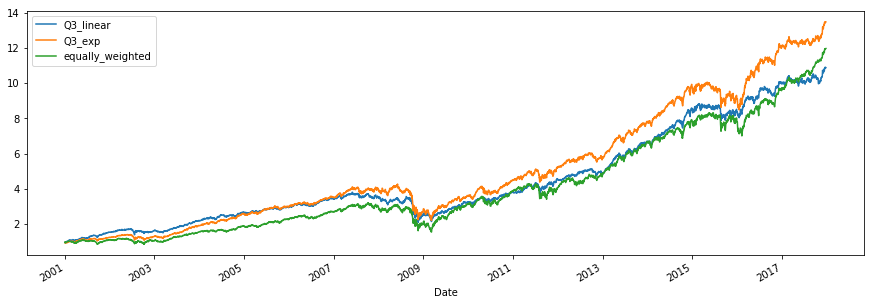

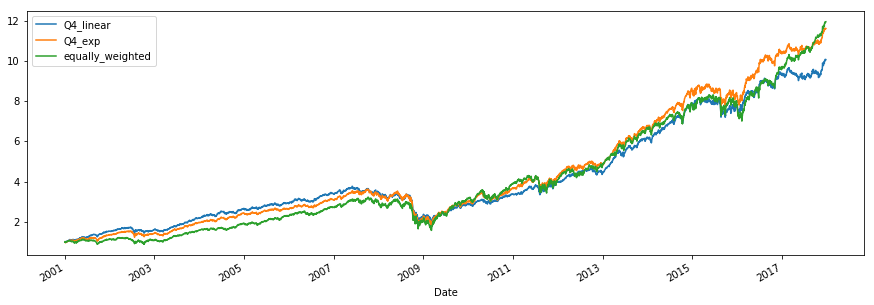

In [8]:
### Interesting, the performance is not much better than equal weighted:
### However, I think this would be different with a smaller portfolio. 

for q, Q in enumerate(Q_list):
    df_performance = pd.concat([pd.concat(performance[m][q], axis=0) 
                                for m, _ in enumerate(models)], axis=1)
    
    #get rid of multiple equally_weighted columns
    tmp_mean = df_performance.loc[:, 'equally_weighted'].iloc[:, 0]
    df_performance.drop('equally_weighted', axis=1, inplace=True)
    df_performance['equally_weighted'] = tmp_mean
    
    #plot
    np.cumprod(1+df_performance).plot(figsize=(15,5));